## Analyzing 2021 FCC Data 

This notebook contains the code used to wrangle, join, and analyze the [Fixed Broadband Deployment Data](https://www.fcc.gov/general/broadband-deployment-data-fcc-form-477) from FCC Form 477. 

All csv files can be found in the "data" folder of the [working](https://github.com/danielgrzenda/broadbandequity/tree/working) branch of our Broadband Equity Github repo.

##### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_pipeline.spatial_operations as so
import data_pipeline.fetch_census_data as fetch

##### Importing Chicago FCC data

First, we use the FCC IL Dec 2020 csv file (which can be found [here](https://us-fcc.app.box.com/v/IL-Dec2020-v1)). Since it is a large file and we only want data on Chicago, we filter for Cook County data only and then export it as a new csv file which is saved in the "data" folder. **DO NOT RUN THE FOLLOWING CHUNKS OF CODE!!!**

In [2]:
%%script false --no-raise-error

# FCC IL

fcc_df = pd.read_csv("../../IL-Fixed-Dec2020-v1.csv",
                     index_col=0,parse_dates=[0])

In [3]:
%%script false --no-raise-error

#changing BlockCode column to string type

fcc_df['BlockCode']=fcc_df['BlockCode'].astype(str)

In [4]:
%%script false --no-raise-error

# Extracting state, county, tract, block numbers from BlockCode column
# IL state=17
# Cook County=031

fcc_df['state'] = fcc_df['BlockCode'].str[:2]
fcc_df['county'] = fcc_df['BlockCode'].str[2:5]
fcc_df['tract'] = fcc_df['BlockCode'].str[5:11]
fcc_df['block'] = fcc_df['BlockCode'].str[-4:]

In [5]:
%%script false --no-raise-error

# Filtering for Cook County only 
# 3408835 -> 763788 rows

chi_fcc = fcc_df[(fcc_df.county == "031")]

In [6]:
%%script false --no-raise-error

# Filtering for Chicago only
# 763788 -> 759684 rows

chi_fcc = chi_fcc.astype({'block':'int64'})
chicago_blocks = pd.read_csv("../../ChicagoCensusBlocks.csv").BLOCKCE10
chi_fcc = chi_fcc[chi_fcc.block.isin(chicago_blocks)]


In [7]:
%%script false --no-raise-error

# export final dataframe to csv file

chi_fcc.to_csv(r'data/chi_fcc.csv', index = False)

In [8]:
%%script false --no-raise-error

# final dataframe looks like this
chi_fcc.head(5)

Don't accidentally commit chi_fcc.csv to the repository!!

##### Analysis

In [9]:
chi_fcc = pd.read_csv("data/chi_fcc.csv",index_col=0,parse_dates=[0])
chi_fcc.head()

,FRN,ProviderName,DBAName,HoldingCompanyName,HocoNum,HocoFinal,StateAbbr,BlockCode,TechCode,Consumer,MaxAdDown,MaxAdUp,Business,state,county,tract,block
Provider_Id,,,,,,,,,,,,,,,,,
69644,7097355,"TOWERSTREAM, INC.",Towerstream,"Towerstream, Inc.",190373,"Towerstream, Inc.",IL,170310207023015,70,0,0.0,0.0,1,17,31,20702,3015
69644,7097355,"TOWERSTREAM, INC.",Towerstream,"Towerstream, Inc.",190373,"Towerstream, Inc.",IL,170310803004005,70,0,0.0,0.0,1,17,31,80300,4005
69644,7097355,"TOWERSTREAM, INC.",Towerstream,"Towerstream, Inc.",190373,"Towerstream, Inc.",IL,170310810005003,70,0,0.0,0.0,1,17,31,81000,5003
69644,7097355,"TOWERSTREAM, INC.",Towerstream,"Towerstream, Inc.",190373,"Towerstream, Inc.",IL,170310813003001,70,0,0.0,0.0,1,17,31,81300,3001
69644,7097355,"TOWERSTREAM, INC.",Towerstream,"Towerstream, Inc.",190373,"Towerstream, Inc.",IL,170310815002006,70,0,0.0,0.0,1,17,31,81500,2006


In [10]:
# drop columns we don't need
chi_fcc = chi_fcc.reset_index()[["DBAName","HocoNum","TechCode","Consumer","MaxAdDown","MaxAdUp","tract","block"]]
chi_fcc.head()

,DBAName,HocoNum,TechCode,Consumer,MaxAdDown,MaxAdUp,tract,block
0,Towerstream,190373,70,0,0.0,0.0,20702,3015
1,Towerstream,190373,70,0,0.0,0.0,80300,4005
2,Towerstream,190373,70,0,0.0,0.0,81000,5003
3,Towerstream,190373,70,0,0.0,0.0,81300,3001
4,Towerstream,190373,70,0,0.0,0.0,81500,2006


This data includes satellite.

From FCC documentation:
- FRN: FCC registration number
- DBAName: Name doing business as
- HocoNum: holding company number
- TechCode: technology of transmission (https://www.fcc.gov/general/technology-codes-used-fixed-broadband-deployment-data)
- Consumer: (0/1) where 1 = Provider can or does offer consumer/mass market/residential service in the block
- MaxAdDown: Maximum advertised downstream speed/bandwidth (in Mbps) offered by the provider in the block for Consumer service
- MaxAdUp: Maximum advertised upstream speed/bandwidth (in Mbps) offered by the provider in the block for Consumer service

One reason why it's a good idea for us to bring in technology of transmission is that providers submit one record per tract _per technology_ (along with that technology's up/down speed) (Source: FAQ https://transition.fcc.gov/form477/477faqs.pdf). 

In [11]:
print(f"Average proportion of total blocks with residential service offered per provider: {int(chi_fcc.Consumer.mean()*100)}%")

Average proportion of total blocks with residential service offered per provider: 83%


The Consumer mean number doesn't tell us much. The reason is that, per the Form 477 instructions https://us-fcc.app.box.com/v/Form477Instructions, ISPs report "all census blocks in which the filer (including affiliates) makes broadband connections available to end-user premises". That means that ISPs DON'T report blocks that they don't make broadband connections available. So the 83% just means that in 17% of provider-block combinations, the provider makes broadband connections available but doesn't offer residential service; it doesn't tell us anything about the other providers who don't offer service. (Also note that providers don't have to report blocks where they offer non-broadband internet, defined as less than 200 kbps.)

We don't want to include Consumer=0 blocks in our analysis; we're confining our analysis here to the speed of internet where it is at least offered residentially. So we'll filter our dataset to remove Consumer=0 rows. (Note that later on we will be able to see if there are populated Chicago-area blocks with no residential internet service.)

In [12]:
chi_fcc = chi_fcc[chi_fcc.Consumer==1][["DBAName","HocoNum","TechCode","MaxAdDown","MaxAdUp","tract","block"]]
chi_fcc

,DBAName,HocoNum,TechCode,MaxAdDown,MaxAdUp,tract,block
15273,Verizon Wireless,131425,70,300.0,50.0,10701,1014
15274,Verizon Wireless,131425,70,300.0,50.0,30200,3005
15275,Verizon Wireless,131425,70,300.0,50.0,30706,1011
15276,Verizon Wireless,131425,70,300.0,50.0,30900,2000
15277,Verizon Wireless,131425,70,300.0,50.0,31400,3003
...,...,...,...,...,...,...,...
759679,"VSAT Systems, LLC.",300167,60,2.0,1.3,980100,1006
759680,"VSAT Systems, LLC.",300167,60,2.0,1.3,980100,1007
759681,"VSAT Systems, LLC.",300167,60,2.0,1.3,980100,1008
759682,"VSAT Systems, LLC.",300167,60,2.0,1.3,980100,1009


In [13]:
print(f"Number of unique DBAS: {len(set(chi_fcc.DBAName))}")
print(f"Number of unique holding companies: {len(set(chi_fcc.HocoNum))}")
print(f"Number of tracts: {len(set(chi_fcc.tract))}")
print(f"Number of blocks: {len(set(chi_fcc.block))}")


Number of unique DBAS: 34
Number of unique holding companies: 34
Number of tracts: 1318
Number of blocks: 651


In [14]:
# to look further at providers, we will remove rows representing one providers's multiple technologies in one block
remove_tech = chi_fcc.drop(columns=["TechCode"]).drop_duplicates()

# proportion of each provider (by business name)
remove_tech.DBAName.value_counts(normalize=True)
# remove_tech.HocoNum.value_counts()
# note: the above line returns essentially the same table; each DBA company has a unique holding company

AT&T Illinois                        0.280633
Viasat Inc                           0.155002
VSAT Systems, LLC.                   0.154128
HughesNet                            0.154128
Comcast                              0.132521
T-Mobile                             0.067961
WOW                                  0.025988
RCN                                  0.021975
e-vergent.com, LLC                   0.004338
XLBroadband                          0.001844
Everywhere Wireless, LLC             0.000588
Webpass, Inc.                        0.000298
Surf Broadband Solutions             0.000214
Verizon Wireless                     0.000128
DLS Computer Services                0.000072
Urban Communications                 0.000052
12Global                             0.000049
UpstreamNetwork                      0.000028
Cable ONE                            0.000009
Mediacom Illinois LLC                0.000008
Future Link IT                       0.000008
MidwestTelecomofAmerica           

This indicates that there are 34 different companies offering broadband in the Chicago area. However, 8 companies make up more than 99% of the provider-block entries: AT&T Illinois, Viasat, VSAT, HughesNet, Comcast, T-Mobile, WOW, and RCN.

Note: Unlike all the others, I can barely find anything about "VSAT Systems, LLC." online. It also has precisely the same number of entries as HughesNet, which makes me wonder whether it's somehow related to them in a contractual relationship or something similar.

In [15]:
# note we can drop holding companies column as we determined it's equivalent to DBA Name

chi_fcc = chi_fcc[["DBAName","TechCode","MaxAdDown","MaxAdUp","tract","block"]]

Now let's take a closer look at the technologies involved.

In [16]:
# to look further at technologies, we will remove rows representing one technology's multiple providers in one block
remove_providers = chi_fcc.drop(columns=["DBAName"]).drop_duplicates()

# proportion of each TechCode (see next chunk for explanations)
remove_providers.TechCode.value_counts(normalize=True)

60    0.463553
43    0.139280
11    0.127200
12    0.094232
70    0.075392
42    0.039187
50    0.032198
10    0.028388
41    0.000424
30    0.000117
20    0.000024
0     0.000003
40    0.000002
Name: TechCode, dtype: float64

In [17]:
fcc_grouptech = chi_fcc.groupby(["TechCode"])

# average speeds by tech type
tech_summary = round(fcc_grouptech.mean()[["MaxAdDown","MaxAdUp"]])

# add the proportions of provider-blocks with technology
tech_summary["% of total"] = round(remove_providers.TechCode.value_counts(normalize=True).sort_index()*100,2)
tech_summary = tech_summary.sort_values(by=["% of total"],ascending=False)

# rename for clarity
tech_names = {
    0: "unknown",10:"copper line (asym xDSL)",11:"copper line (ADSL)",12:"copper line (VDSL)",20:"copper line (sym xDSL)",30:"copper line (other)",
    40:"cable modem (other)",41:"cable modem (DOCSIS 1-2)",42:"cable modem (DOCSIS 3.0)",43:"cable modem (DOCSIS 3.1)",50:"optical fiber",60:"satellite",70:"terrestrial fixed wireless"
    }
tech_summary = tech_summary.rename(index=tech_names)

tech_summary

,MaxAdDown,MaxAdUp,% of total
TechCode,,,
satellite,24.0,2.0,46.36
cable modem (DOCSIS 3.1),1000.0,34.0,13.93
copper line (ADSL),16.0,1.0,12.72
copper line (VDSL),84.0,17.0,9.42
terrestrial fixed wireless,36.0,12.0,7.54
cable modem (DOCSIS 3.0),832.0,40.0,3.92
optical fiber,1000.0,1000.0,3.22
copper line (asym xDSL),4.0,0.0,2.84
cable modem (DOCSIS 1-2),25.0,4.0,0.04


Clearly, technology type has a _big_ influence on internet speed. 

Also note that MaxAdDown and MaxAdUp generally track each other; optical fiber has *much* faster MaxAdUp than the other technology types.

How much variation in internet speed is there among each technology?

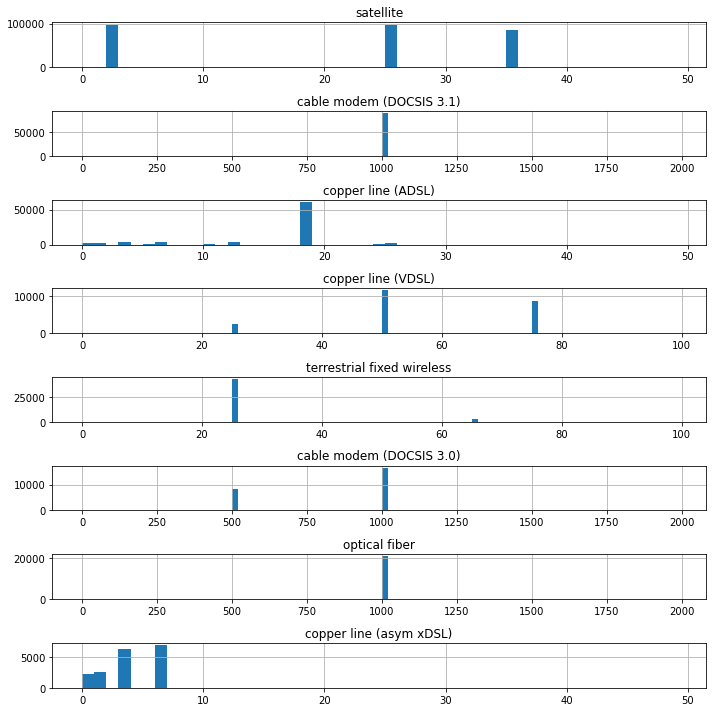

In [18]:
print("Warning: Differently-scaled x axes")

plt.rcParams['figure.figsize'] = [10, 10]  # add more space
fig, axes = plt.subplots(8, 1)
chi_fcc[chi_fcc.TechCode==60].hist("MaxAdDown",bins=range(0,50,1),ax=axes[0])
chi_fcc[chi_fcc.TechCode==43].hist("MaxAdDown",bins=range(0,2000,20),ax=axes[1])
chi_fcc[chi_fcc.TechCode==11].hist("MaxAdDown",bins=range(0,50,1),ax=axes[2])
chi_fcc[chi_fcc.TechCode==12].hist("MaxAdDown",bins=range(0,100,1),ax=axes[3])
chi_fcc[chi_fcc.TechCode==70].hist("MaxAdDown",bins=range(0,100,1),ax=axes[4])
chi_fcc[chi_fcc.TechCode==42].hist("MaxAdDown",bins=range(0,2000,20),ax=axes[5])
chi_fcc[chi_fcc.TechCode==50].hist("MaxAdDown",bins=range(0,2000,20),ax=axes[6])
chi_fcc[chi_fcc.TechCode==10].hist("MaxAdDown",bins=range(0,50,1),ax=axes[7])

techs = [60,43,11,12,70,42,50,10]

for i in range(0,8):
    axes[i].set_title(tech_names[techs[i]])

fig.tight_layout()


We can see that advertised speeds cluster into just a few levels for each technology type. 

Based on these results, we will create dummy variables for the following technology types:
- legacy telephone line (ADSL and asym xDSL): slowest, 16%
- satellite: slow, 46%
- fixed wireless: slow, 8%
- modern telephone line (VDSL): moderate speed, 9%
- modern cable (DOCSIS 3.0 and 3.1): fast, 18%
- fiber: fastest, 3%

In [19]:
tech_names = {
    0: "unknown",10:"copper line (asym xDSL)",11:"copper line (ADSL)",12:"copper line (VDSL)",20:"copper line (sym xDSL)",30:"copper line (other)",
    40:"cable modem (other)",41:"cable modem (DOCSIS 1-2)",42:"cable modem (DOCSIS 3.0)",43:"cable modem (DOCSIS 3.1)",50:"optical fiber",60:"satellite",70:"terrestrial fixed wireless"
    }

chi_fcc["legacy telephone"] = (chi_fcc["TechCode"]==10)  | (chi_fcc["TechCode"]==11)
chi_fcc["satellite"] = chi_fcc["TechCode"]==60
chi_fcc["fixed wireless"] = chi_fcc["TechCode"]==70
chi_fcc["modern telephone"] = chi_fcc["TechCode"]==12
chi_fcc['modern cable'] = (chi_fcc["TechCode"]==42) | (chi_fcc["TechCode"]==43)
chi_fcc['fiber'] = chi_fcc["TechCode"]==50
chi_fcc['other internet'] = (chi_fcc["TechCode"]==0) | (chi_fcc["TechCode"]==20) | (chi_fcc["TechCode"]==30) | (chi_fcc["TechCode"]==40)
chi_fcc.head()

# note that we now have a row per technology per provider per block

,DBAName,TechCode,MaxAdDown,MaxAdUp,tract,block,legacy telephone,satellite,fixed wireless,modern telephone,modern cable,fiber,other internet
15273,Verizon Wireless,70,300.0,50.0,10701,1014,False,False,True,False,False,False,False
15274,Verizon Wireless,70,300.0,50.0,30200,3005,False,False,True,False,False,False,False
15275,Verizon Wireless,70,300.0,50.0,30706,1011,False,False,True,False,False,False,False
15276,Verizon Wireless,70,300.0,50.0,30900,2000,False,False,True,False,False,False,False
15277,Verizon Wireless,70,300.0,50.0,31400,3003,False,False,True,False,False,False,False


In [20]:
# before aggregating by block, make sure we don't accidentally combine unique blocks from different tracts
chi_fcc['block'] = chi_fcc['tract'].astype(str)+chi_fcc['block'].astype(str) # (be sure to only run this line once)

In [21]:
fcc_groupblock = chi_fcc.groupby(['block'])

# number of providers of each technology per block
fcc_blocks = fcc_groupblock.sum()

# number of providers total in each block
fcc_blocks["n_providers"] = fcc_groupblock["DBAName"].nunique()

# fix tract numbers
fcc_blocks["tract"] = fcc_groupblock["tract"].first()

# drop unneeded columns
fcc_blocks = fcc_blocks[["tract","legacy telephone","satellite","fixed wireless","modern telephone","modern cable","fiber","other internet","n_providers"]]

fcc_blocks

,tract,legacy telephone,satellite,fixed wireless,modern telephone,modern cable,fiber,other internet,n_providers
block,,,,,,,,,
1001001000,100100,1,3,0,1,1,0,0,5
1001001001,100100,1,3,0,1,1,1,0,5
1001001002,100100,1,3,0,1,1,1,0,5
1001001003,100100,2,3,0,1,1,1,0,5
1001001004,100100,1,3,0,1,1,0,0,5
...,...,...,...,...,...,...,...,...,...
9801001006,980100,2,3,1,0,1,0,0,6
9801001007,980100,1,3,0,0,0,0,0,4
9801001008,980100,2,3,0,1,0,0,0,4


Mean providers per block: 5.45
Median providers per block: 6.0
Max providers per block: 10


<AxesSubplot:>

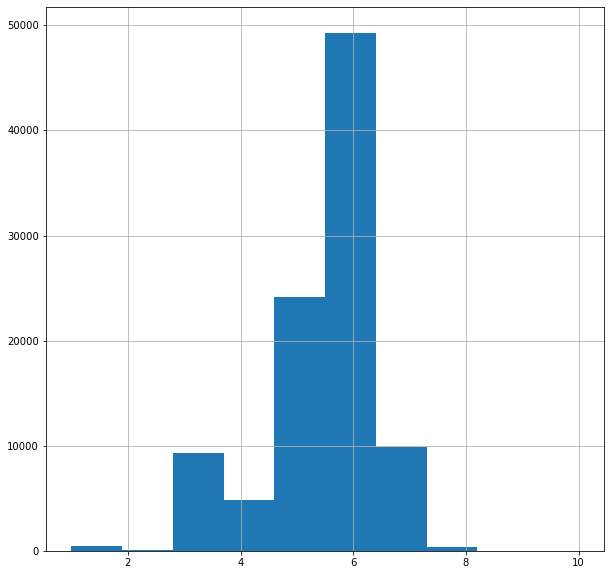

In [22]:
print(f"Mean providers per block: {round(fcc_blocks['n_providers'].mean(),2)}")
print(f"Median providers per block: {round(fcc_blocks['n_providers'].median(),2)}")
print(f"Max providers per block: {round(fcc_blocks['n_providers'].max(),2)}")
fcc_blocks['n_providers'].hist()

In [23]:
print('Percent of blocks with each technology')
round(fcc_blocks[[
    "satellite","legacy telephone","fixed wireless","modern telephone","modern cable","fiber","other internet"
    ]].astype(bool).sum(axis=0)/len(fcc_blocks)*100)

Percent of blocks with each technology


satellite           100.0
legacy telephone     83.0
fixed wireless       46.0
modern telephone     61.0
modern cable         86.0
fiber                21.0
other internet        0.0
dtype: float64

In [24]:
print("Average number of providers offering each technology where it's offered")
round(fcc_blocks[[
    "satellite","legacy telephone","fixed wireless","modern telephone","modern cable","fiber","other internet"
    ]].replace(0,np.NaN)  # don't include blocks where tech isn't offered in the mean
    .mean(axis=0),2)

Average number of providers offering each technology where it's offered


satellite           2.99
legacy telephone    1.21
fixed wireless      1.05
modern telephone    1.00
modern cable        1.34
fiber               1.02
other internet      1.00
dtype: float64

In [25]:
fcc_blocks.index = fcc_blocks.index.astype('int64')

In [26]:
import geopandas as gpd

In [27]:
test_blocks = gpd.read_file('geo/blocks.shp')

In [28]:
test_blocks['tract_bloc']= test_blocks['tract_bloc'].astype('int')

In [29]:
test_blocks['tract_bloc'][0] in fcc_blocks.index

True

In [30]:
test_blocks.index[1]

1

In [31]:
test_blocks.index[0] in fcc_blocks.index

False

In [32]:
fcc_blocks.sort_index()

,tract,legacy telephone,satellite,fixed wireless,modern telephone,modern cable,fiber,other internet,n_providers
block,,,,,,,,,
101001000,10100,2,3,0,1,3,0,0,6
101001001,10100,1,3,0,1,3,0,0,6
101001002,10100,1,3,0,1,3,0,0,6
101001003,10100,2,3,0,1,3,0,0,6
101002000,10100,2,3,0,1,3,0,0,6
...,...,...,...,...,...,...,...,...,...
9801001006,980100,2,3,1,0,1,0,0,6
9801001007,980100,1,3,0,0,0,0,0,4
9801001008,980100,2,3,0,1,0,0,0,4


In [33]:
fcc_blocks = fcc_blocks.reset_index()

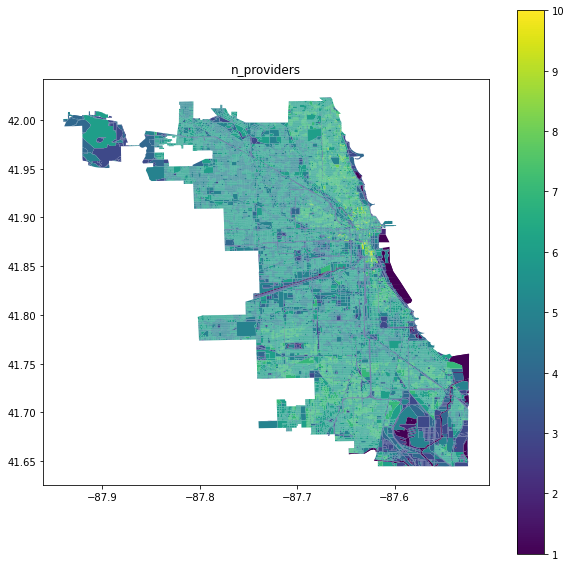

In [34]:
so.simple_map(fcc_blocks,'n_providers','block')

In [35]:
fcc_grouptract = fcc_blocks.groupby('tract')

fcc_tracts = fcc_grouptract.mean().reset_index()

fcc_tracts

,tract,block,legacy telephone,satellite,fixed wireless,modern telephone,modern cable,fiber,other internet,n_providers
0,10100,1.010023e+08,1.225806,3.000000,0.032258,0.774194,2.677419,0.032258,0.000000,5.806452
1,10201,1.020120e+08,1.238806,3.000000,0.402985,0.805970,2.626866,0.014925,0.000000,6.343284
2,10202,1.020214e+08,1.160000,3.000000,0.080000,0.200000,2.400000,0.000000,0.000000,5.920000
3,10300,1.030026e+08,1.306122,3.000000,0.244898,0.734694,2.612245,0.000000,0.000000,6.102041
4,10400,1.040023e+08,1.129032,2.935484,0.580645,0.741935,2.387097,0.000000,0.000000,6.096774
...,...,...,...,...,...,...,...,...,...,...
1313,843700,8.437002e+09,1.016129,3.000000,0.274194,0.532258,1.370968,0.903226,0.000000,5.483871
1314,843800,8.438001e+09,1.000000,3.000000,0.619565,0.521739,0.934783,0.000000,0.000000,5.510870
1315,843900,8.439002e+09,1.017544,2.824561,0.491228,0.543860,0.666667,0.017544,0.000000,4.771930
1316,980000,9.800001e+09,0.174757,3.000000,0.368932,0.029126,0.155340,0.000000,0.009709,3.679612


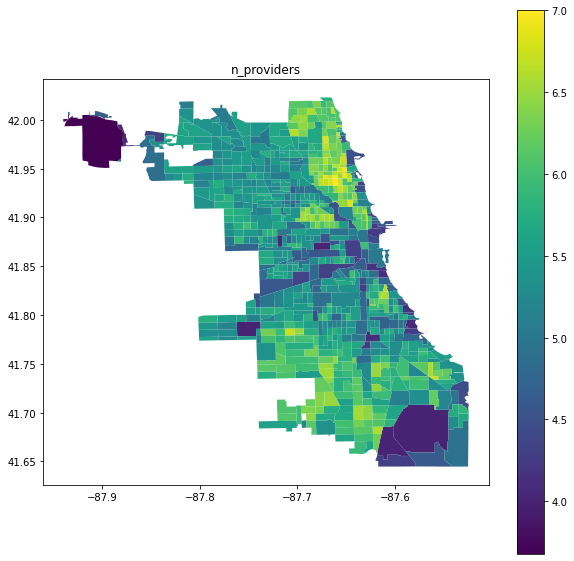

In [36]:
so.simple_map(fcc_tracts,'n_providers','tract')

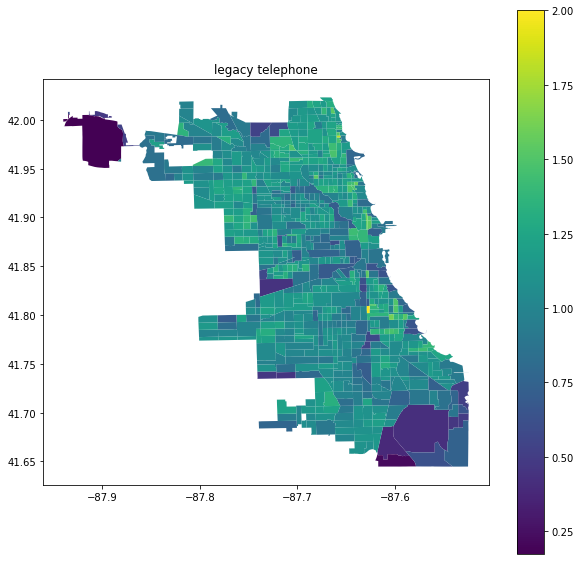

In [37]:
so.simple_map(fcc_tracts,'legacy telephone','tract')

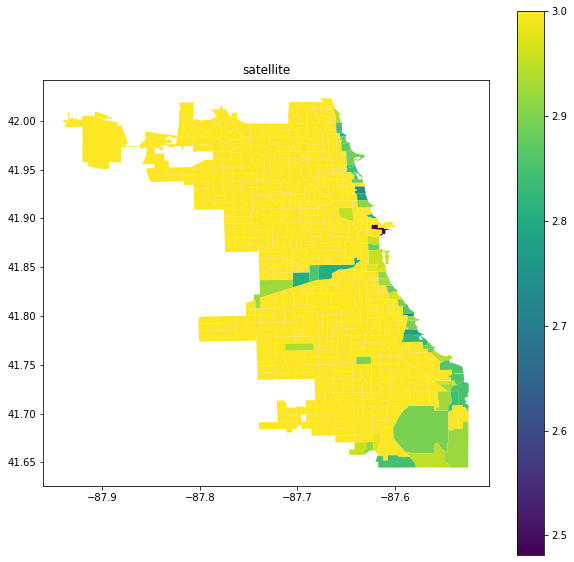

In [38]:
so.simple_map(fcc_tracts,'satellite','tract')


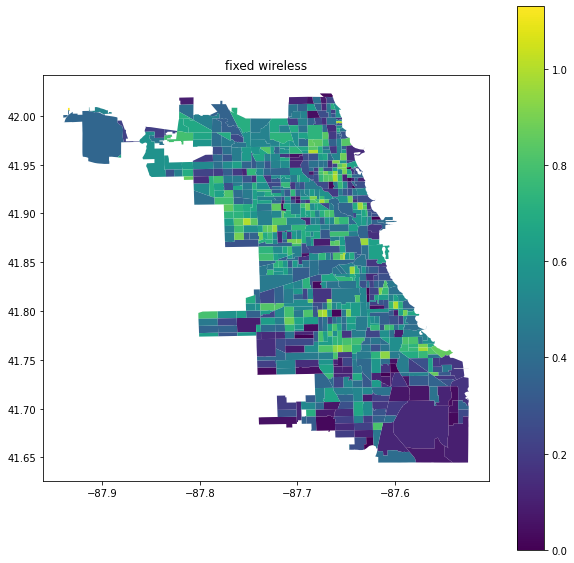

In [39]:
so.simple_map(fcc_tracts,'fixed wireless','tract')

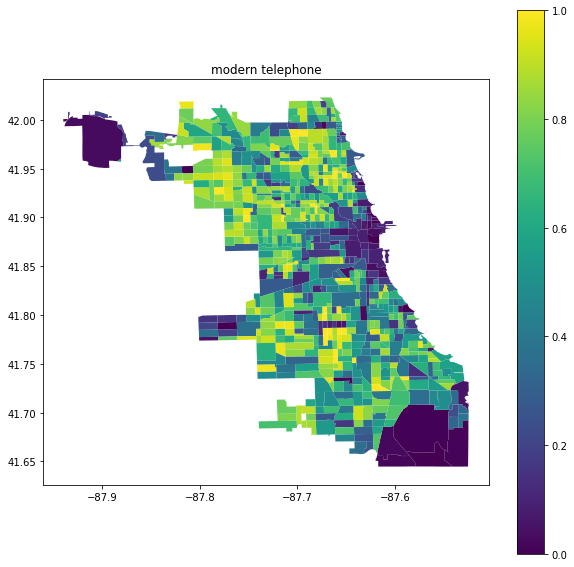

In [40]:
so.simple_map(fcc_tracts,'modern telephone','tract')

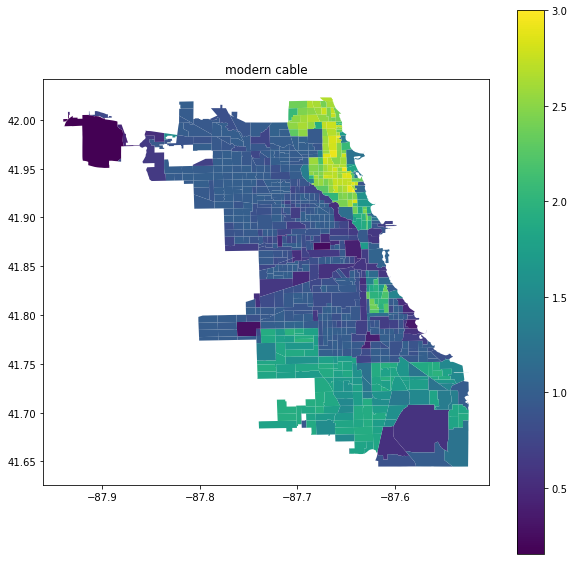

In [41]:
so.simple_map(fcc_tracts,'modern cable','tract')

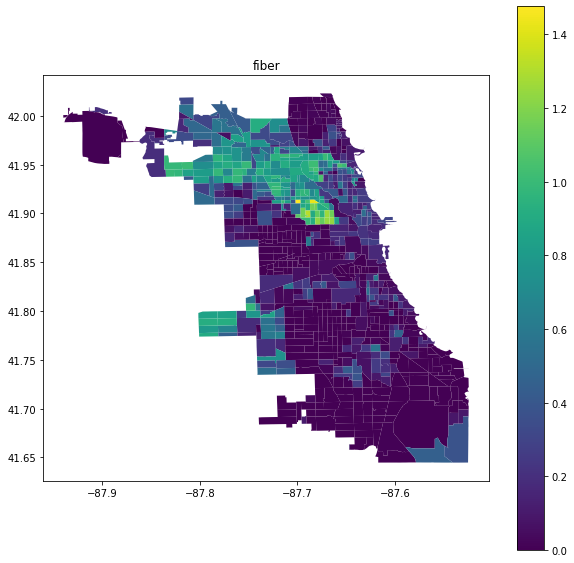

In [42]:
so.simple_map(fcc_tracts,'fiber','tract')


##### [Old] Tract-level analysis

We have 1319 tracts with an average of ~480 data points per tract.

In [43]:
fcc_grouped = chi_fcc.groupby(['tract'])
fcc_grouped.count()

,DBAName,TechCode,MaxAdDown,MaxAdUp,block,legacy telephone,satellite,fixed wireless,modern telephone,modern cable,fiber,other internet
tract,,,,,,,,,,,,
10100,240,240,240,240,240,240,240,240,240,240,240,240
10201,544,544,544,544,544,544,544,544,544,544,544,544
10202,172,172,172,172,172,172,172,172,172,172,172,172
10300,390,390,390,390,390,390,390,390,390,390,390,390
10400,244,244,244,244,244,244,244,244,244,244,244,244
...,...,...,...,...,...,...,...,...,...,...,...,...
843700,440,440,440,440,440,440,440,440,440,440,440,440
843800,559,559,559,559,559,559,559,559,559,559,559,559
843900,317,317,317,317,317,317,317,317,317,317,317,317


In [44]:
# We'll use median advertised speeds for tract aggregation (outliers less important)
fcc_tracts = fcc_grouped.median()
# also, we can drop the Consumer column at this point
fcc_tracts = fcc_tracts[["MaxAdDown","MaxAdUp"]]
fcc_tracts

,MaxAdDown,MaxAdUp
tract,,
10100,35.0,3.0
10201,35.0,3.0
10202,35.0,3.0
10300,35.0,3.0
10400,35.0,3.0
...,...,...
843700,35.0,3.0
843800,25.0,3.0
843900,25.0,3.0


In [45]:
print(f"Median block advertised downstream speed: {fcc_tracts.MaxAdDown.median()} Mbps")
print(f"Median block advertised upstream speed: {fcc_tracts.MaxAdUp.median()} Mbps")

Median block advertised downstream speed: 25.0 Mbps
Median block advertised upstream speed: 3.0 Mbps


Let's look at some histograms of what the median advertised speed looks like.

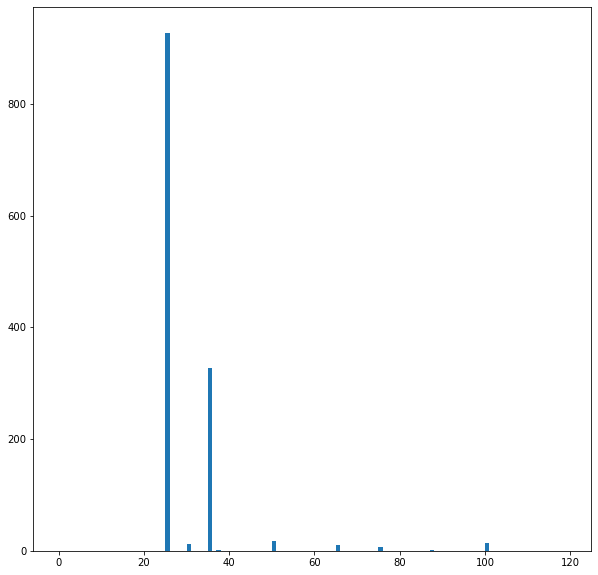

In [46]:
median_tract_down = plt.hist(fcc_tracts.MaxAdDown,bins=range(0,120,1))

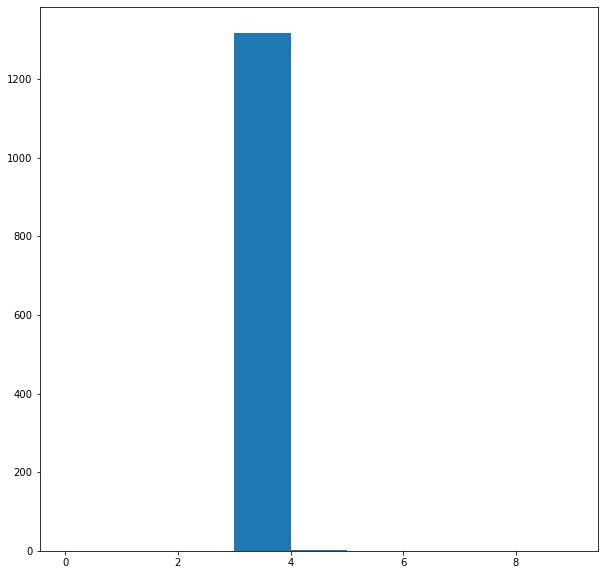

In [47]:
median_tract_up = plt.hist(fcc_tracts.MaxAdUp,bins=range(0,10,1))

That's not very exciting. It is fairly interesting, though, in that it demonstrates the very large majority of Chicago tracts have pretty much the same median advertised speed.

How much variation at a block level are we losing with our median estimates?

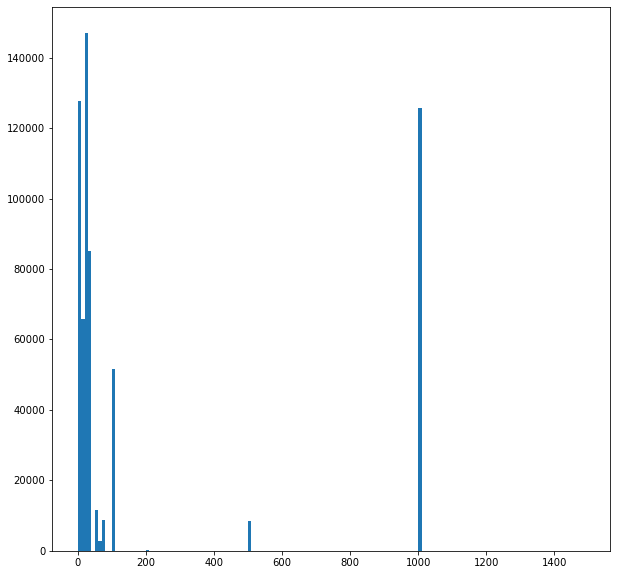

In [48]:
# this are all block/technology/providers
median_block_down = plt.hist(chi_fcc.MaxAdDown,bins=range(0,1500,10))

Answer: A lot, clearly! 

A final note: It would be nice to have access to the FCC's Fixed Broadband Subscription data, which they also require to be filed and which lists the actual # of customers. But it's not publicly available.

Also note that the FCC's map of Form 477 Broadband Deployment is quite nice: https://broadbandmap.fcc.gov/#/location-summary?version=dec2020&lat=41.789403&lon=-87.599576&tech=acfosw&speed=25_3&vlat=41.78958400043072&vlon=-87.599651&vzoom=18.74542480573349

In [49]:
test = pd.read_csv('data/chicago_internet.csv')

In [50]:
test["community_area"]=[i.upper() for i in test["name"]]
test

,Unnamed: 0,name,comm_num,total_pop,total_households,hh_no_internet,hh_no_internet(%),hh_internet,hh_internet(%),internet_rr,...,total_black,total_black(%),total_white,total_white(%),total_asian,total_asian(%),ccvi_score,ccvi_cat,hardship_score,community_area
0,0,Albany Park,14,49806,16909,2674,15.814064,13488,79.768171,95.582234,...,2461,4.941172,16040,32.204955,7391,14.839578,38.2,MEDIUM,53.0,ALBANY PARK
1,1,Archer Heights,57,13726,3919,772,19.698903,2886,73.641235,93.340138,...,131,0.954393,2109,15.365001,819,5.966778,53.3,HIGH,67.0,ARCHER HEIGHTS
2,2,Armour Square,34,13538,5396,1488,27.575982,3685,68.291327,95.867309,...,1135,8.383809,1878,13.872064,9886,73.024080,30.9,LOW,82.0,ARMOUR SQUARE
3,3,Ashburn,70,43356,13124,1840,14.020116,10449,79.617495,93.637610,...,19888,45.871390,4110,9.479657,410,0.945659,45.1,MEDIUM,37.0,ASHBURN
4,4,Auburn Gresham,71,45909,17161,5282,30.779092,10394,60.567566,91.346658,...,43791,95.386526,524,1.141388,141,0.307129,48.2,HIGH,74.0,AUBURN GRESHAM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,72,West Lawn,65,31886,9272,1752,18.895600,7094,76.509922,95.405522,...,845,2.650066,4028,12.632503,142,0.445337,48.5,HIGH,56.0,WEST LAWN
73,73,West Pullman,53,30020,10598,2176,20.532176,8101,76.438951,96.971127,...,27579,91.868754,290,0.966023,0,0.000000,49.2,HIGH,62.0,WEST PULLMAN
74,74,West Ridge,2,78466,25714,3676,14.295714,20875,81.181458,95.477172,...,9086,11.579538,31836,40.572987,18650,23.768256,36.0,MEDIUM,46.0,WEST RIDGE
75,75,West Town,24,83757,37819,3187,8.426981,33590,88.817790,97.244771,...,5727,6.837637,53095,63.391717,4125,4.924961,18.2,LOW,10.0,WEST TOWN


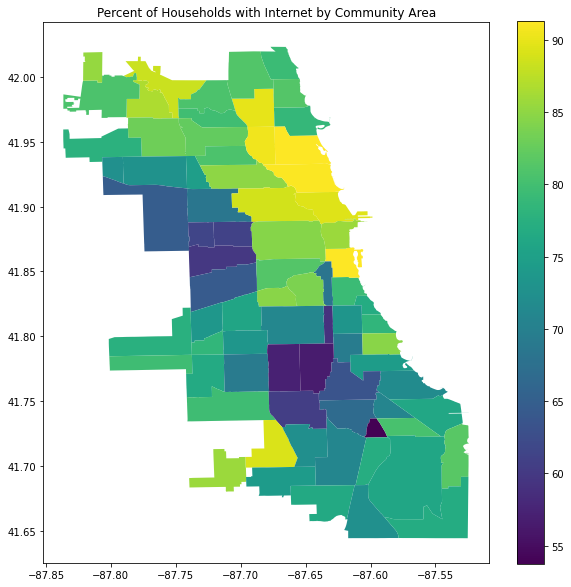

In [51]:
so.simple_map(test,'hh_internet(%)','community_area','Percent of Households with Internet by Community Area')